https://towardsdatascience.com/extracting-text-from-pdf-files-with-python-a-comprehensive-guide-9fc4003d517

In [1]:
%autosave 300
%load_ext autoreload
%autoreload 2 
%reload_ext autoreload
%config Completer.use_jedi = False

Autosaving every 300 seconds


In [2]:
import os

os.chdir(
    "/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments"
)
print(os.getcwd())

/mnt/batch/tasks/shared/LS_root/mounts/clusters/copilot-model-run/code/Users/Soutrik.Chowdhury/unstructured_data_experiments


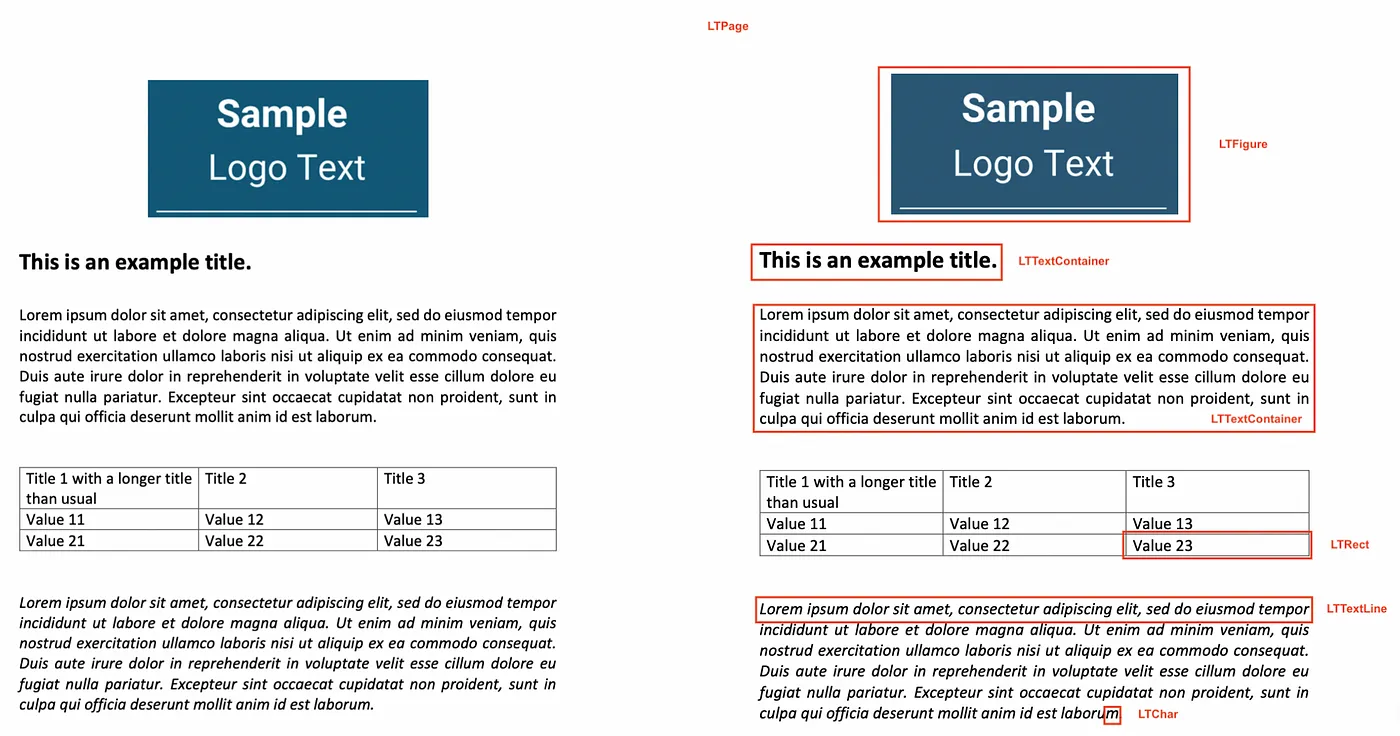

For the preliminary analysis, we used the PDFMiner Python library to separate text from a PDF document into individual pages and analyze each page's layout. PDF files lack structured information, recognizing only individual characters and their positions on the page. PDFMiner reconstructs content by analyzing these characters and their positions to form words, sentences, lines, and paragraphs.

Key steps:

1. **Page Separation**: Uses `extract_pages()` to convert each page into an `LTPage` object.
2. **Component Identification**:
   - **LTFigure**: Areas containing figures or embedded images.
   - **LTTextContainer**: Groups of text lines, further broken down into `LTTextLine` objects containing `LTChar` objects (individual characters with metadata).
   - **LTRect**: 2-dimensional rectangles framing images, figures, or tables.

By classifying page elements into `LTFigure`, `LTTextContainer`, or `LTRect`, we can extract information more effectively.

In [12]:
# To read the PDF
import PyPDF2

# To analyze the PDF layout and extract text
from pdfminer.high_level import extract_pages, extract_text
from pdfminer.layout import LTTextContainer, LTChar, LTRect, LTFigure

# To extract text from tables in PDF
import pdfplumber

# To extract the images from the PDFs
from PIL import Image
from pdf2image import convert_from_path

# To perform OCR to extract text from images
import pytesseract

# To remove the additional created files
import os

In [27]:
# # yield LT pages
# extracted_pages = extract_pages(os.path.join("data", "1. MSA Gateware (Enteron) 1.pdf"))

In [28]:
# extracted_pages = list(extracted_pages)

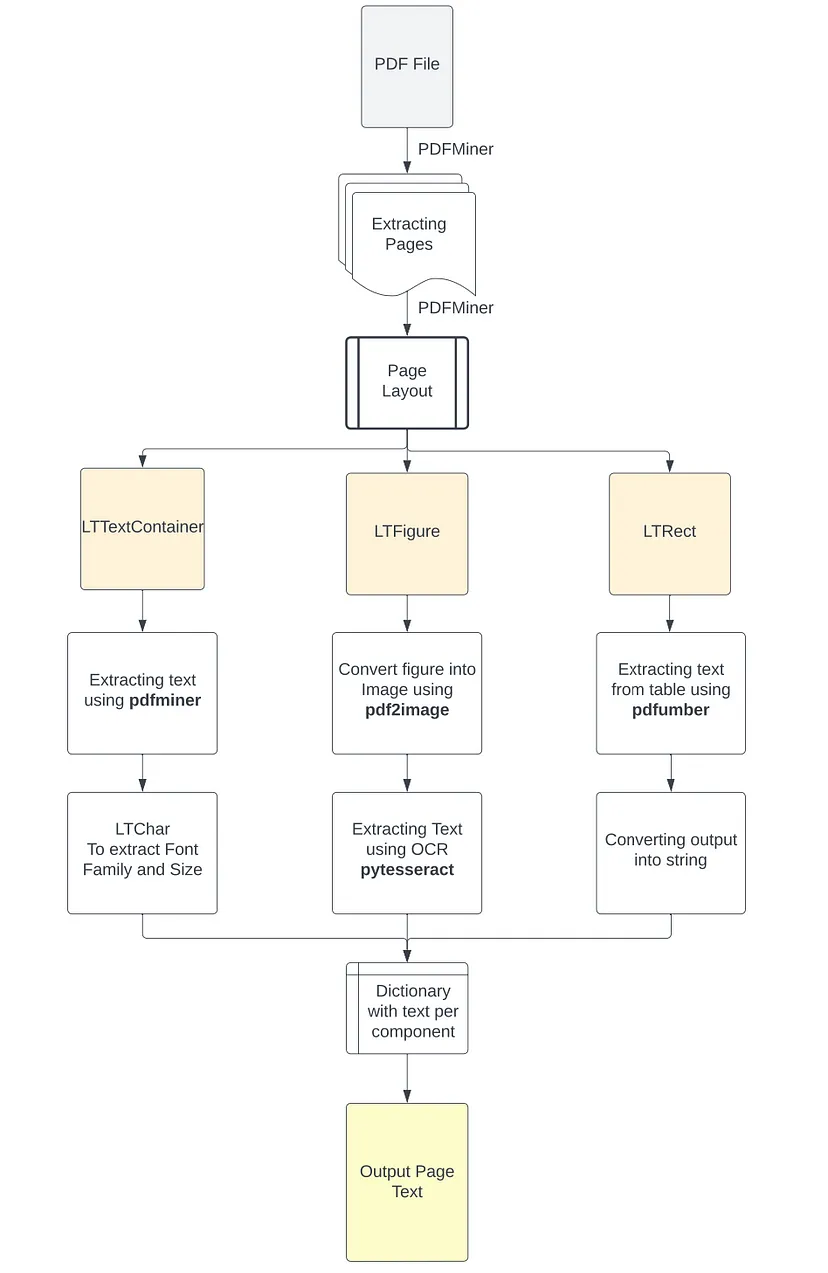

In [15]:
# Create a function to extract text
def text_extraction(element):
    # Extracting the text from the in-line text element
    line_text = element.get_text()
    return line_text

In [16]:
# Extracting tables from the page


def extract_table(pdf_path, page_num, table_num):
    # Open the pdf file
    pdf = pdfplumber.open(pdf_path)
    # Find the examined page
    table_page = pdf.pages[page_num]
    # Extract the appropriate table
    table = table_page.extract_tables()[table_num]

    return table


# Convert table into appropriate fromat
def table_converter(table):
    table_string = ""
    # Iterate through each row of the table
    for row_num in range(len(table)):
        row = table[row_num]
        # Remove the line breaker from the wrapted texts
        cleaned_row = [
            (
                item.replace("\n", " ")
                if item is not None and "\n" in item
                else "None" if item is None else item
            )
            for item in row
        ]
        # Convert the table into a string
        table_string += "|" + "|".join(cleaned_row) + "|" + "\n"
    # Removing the last line break
    table_string = table_string[:-1]
    return table_string


# Create a function to check if the element is in any tables present in the page
def is_element_inside_any_table(element, page, tables):
    x0, y0up, x1, y1up = element.bbox
    # Change the cordinates because the pdfminer counts from the botton to top of the page
    y0 = page.bbox[3] - y1up
    y1 = page.bbox[3] - y0up
    for table in tables:
        tx0, ty0, tx1, ty1 = table.bbox
        if tx0 <= x0 <= x1 <= tx1 and ty0 <= y0 <= y1 <= ty1:
            return True
    return False


# Function to find the table for a given element
def find_table_for_element(element, page, tables):
    x0, y0up, x1, y1up = element.bbox
    # Change the cordinates because the pdfminer counts from the botton to top of the page
    y0 = page.bbox[3] - y1up
    y1 = page.bbox[3] - y0up
    for i, table in enumerate(tables):
        tx0, ty0, tx1, ty1 = table.bbox
        if tx0 <= x0 <= x1 <= tx1 and ty0 <= y0 <= y1 <= ty1:
            return i  # Return the index of the table
    return None

In [17]:
# Create a function to crop the image elements from PDFs
def crop_image(element, pageObj):
    # Get the coordinates to crop the image from PDF
    [image_left, image_top, image_right, image_bottom] = [
        element.x0,
        element.y0,
        element.x1,
        element.y1,
    ]
    # Crop the page using coordinates (left, bottom, right, top)
    pageObj.mediabox.lower_left = (image_left, image_bottom)
    pageObj.mediabox.upper_right = (image_right, image_top)
    # Save the cropped page to a new PDF
    cropped_pdf_writer = PyPDF2.PdfWriter()
    cropped_pdf_writer.add_page(pageObj)
    # Save the cropped PDF to a new file
    with open("cropped_image.pdf", "wb") as cropped_pdf_file:
        cropped_pdf_writer.write(cropped_pdf_file)


# Create a function to convert the PDF to images
def convert_to_images(
    input_file,
):
    images = convert_from_path(input_file)
    image = images[0]
    output_file = "PDF_image.png"
    image.save(output_file, "PNG")


# Create a function to read text from images
def image_to_text(image_path):
    # Read the image
    img = Image.open(image_path)
    # Extract the text from the image
    text = pytesseract.image_to_string(img)
    return text

In [29]:
# Find the PDF path
pdf_path = os.path.join("data", "1. MSA Gateware (Enteron) 1.pdf")

# Create a pdf file object
pdfFileObj = open(pdf_path, "rb")
# Create a pdf reader object
pdfReaded = PyPDF2.PdfReader(pdfFileObj)

In [30]:
len(pdfReaded.pages)

32

In [31]:
# Create the dictionary to extract text from each image
text_per_page = {}
# Create a boolean variable for image detection
image_flag = False

# We extract the pages from the PDF
for pagenum, page in enumerate(extract_pages(pdf_path)):
    print(f"Extracting page {pagenum}")
    # Initialize the variables needed for the text extraction from the page
    pageObj = pdfReaded.pages[pagenum]
    page_text = []
    text_from_images = []
    text_from_tables = []
    page_content = []
    # Initialize the number of the examined tables
    table_in_page = -1
    # Open the pdf file
    pdf = pdfplumber.open(pdf_path)
    # Find the examined page
    page_tables = pdf.pages[pagenum]
    # Find the number of tables in the page
    tables = page_tables.find_tables()
    if len(tables) != 0:
        table_in_page = 0

    # Extracting the tables of the page
    for table_num in range(len(tables)):
        # Extract the information of the table
        table = extract_table(pdf_path, pagenum, table_num)
        # Convert the table information in structured string format
        table_string = table_converter(table)
        # Append the table string into a list
        text_from_tables.append(table_string)

    # Find all the elements
    page_elements = [(element.y1, element) for element in page._objs]
    # Sort all the element as they appear in the page
    page_elements.sort(key=lambda a: a[0], reverse=True)

    # Find the elements that composed a page
    for i, component in enumerate(page_elements):
        # Extract the element of the page layout
        element = component[1]

        # Check the elements for tables
        if table_in_page == -1:
            pass
        else:
            if is_element_inside_any_table(element, page, tables):
                table_found = find_table_for_element(element, page, tables)
                if table_found == table_in_page and table_found != None:
                    page_content.append(text_from_tables[table_in_page])
                    page_text.append("table")
                    table_in_page += 1
                # Pass this iteration because the content of this element was extracted from the tables
                continue

        if not is_element_inside_any_table(element, page, tables):

            # Check if the element is text element
            if isinstance(element, LTTextContainer):
                # Use the function to extract the text and format for each text element
                line_text = text_extraction(element)
                # Append the text of each line to the page text
                page_text.append(line_text)
                page_content.append(line_text)

            # Check the elements for images
            if isinstance(element, LTFigure):
                # Crop the image from PDF
                crop_image(element, pageObj)
                # Convert the croped pdf to image
                convert_to_images("./cropped_image.pdf")
                # Extract the text from image
                image_text = image_to_text("./PDF_image.png")
                text_from_images.append(image_text)
                page_content.append(image_text)
                # Add a placeholder in the text and format lists
                page_text.append("image")
                # Update the flag for image detection
                image_flag = True

    # Create the key of the dictionary
    dctkey = "Page_" + str(pagenum)
    # Add the list of list as value of the page key
    text_per_page[dctkey] = [
        page_text,
        text_from_images,
        text_from_tables,
        page_content,
    ]

Extracting page 0
Extracting page 1
Extracting page 2
Extracting page 3
Extracting page 4
Extracting page 5
Extracting page 6
Extracting page 7
Extracting page 8
Extracting page 9
Extracting page 10
Extracting page 11
Extracting page 12
Extracting page 13
Extracting page 14
Extracting page 15
Extracting page 16
Extracting page 17
Extracting page 18
Extracting page 19
Extracting page 20
Extracting page 21
Extracting page 22
Extracting page 23
Extracting page 24
Extracting page 25
Extracting page 26
Extracting page 27
Extracting page 28
Extracting page 29
Extracting page 30
Extracting page 31


In [32]:
text_per_page.keys()

dict_keys(['Page_0', 'Page_1', 'Page_2', 'Page_3', 'Page_4', 'Page_5', 'Page_6', 'Page_7', 'Page_8', 'Page_9', 'Page_10', 'Page_11', 'Page_12', 'Page_13', 'Page_14', 'Page_15', 'Page_16', 'Page_17', 'Page_18', 'Page_19', 'Page_20', 'Page_21', 'Page_22', 'Page_23', 'Page_24', 'Page_25', 'Page_26', 'Page_27', 'Page_28', 'Page_29', 'Page_30', 'Page_31'])

In [40]:
text_per_page['Page_21']

[['image',
  'Agreement Reference No:  \n',
  ' \n',
  ' \n',
  'table',
  'image',
  ' \n',
  'Real (BRL) \n',
  ' \n',
  'Cotação do Dollar (USD) \n',
  '5,2 \n',
  'Cotação do Euro (EUR) \n',
  '5,8 \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n',
  ' \n'],
 ['DocuSign Envelope ID: 3BDE136F-BA28-419D-A682-AAAD1BA87428\n\nAgreement Reference No:\n\n \n\nProduct & Agility\nValue Real BRL Value Dollar USD Value Euro EUR\n\nStream\n\nLevel Cost/Hour Cost/Month Cost/Hour Cost/Month Cost/Hour Cost/Month\n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\n \n\nBusiness Analyst 1 116,25 18.600,00 22,36 3.576,92 20,04 3.206,90\nAgile Master 2 145,31 23.250,00 27,94 4.471,15 25,05 4.008,62\nJunior Product Designer 2 145,31 23.250,00 27,94 4.471,15 25,05 4.008,62\nSenior Business Analyst 2 145,31 23.250,00 27,94 4.471,15 25,05 4.008,62\nAgile Coach 3 174,38 27.900,00 33,53 5.365,38 30,06 4.810,34\nSenior Agile Master 